# Workflow Debugging

In [1]:
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [1]:
(
    training_data,
    names_list,
    scores_list,
) = Predictor.generate_trainingdata_from_qasm_files(
    source_path="./comp_test_source", target_path="./comp_test/"
)

Calibration files successfully initiated
Checking  qwalk-noancilla_indep_qiskit_13.qasm
Checking  su2random_indep_qiskit_54.qasm
Checking  qpeexact_indep_qiskit_54.qasm
Checking  ghz_indep_qiskit_100.qasm
Checking  wstate_indep_qiskit_26.qasm
Checking  graphstate_indep_qiskit_30.qasm
Checking  graphstate_indep_qiskit_120.qasm
Checking  twolocalrandom_indep_qiskit_128.qasm
Checking  twolocalrandom_indep_qiskit_27.qasm
Checking  ghz_indep_qiskit_81.qasm
Checking  qaoa_indep_qiskit_6.qasm
Checking  graphstate_indep_qiskit_88.qasm
Checking  qftentangled_indep_qiskit_85.qasm
Checking  wstate_indep_qiskit_112.qasm
Checking  qft_indep_qiskit_116.qasm
Checking  ae_indep_qiskit_118.qasm
Checking  wstate_indep_qiskit_71.qasm
Checking  graphstate_indep_qiskit_67.qasm
Checking  ae_indep_qiskit_53.qasm
Checking  qftentangled_indep_qiskit_112.qasm
Checking  ghz_indep_qiskit_39.qasm
Checking  shor_15_4_indep_qiskit_18.qasm
Checking  twolocalrandom_indep_qiskit_70.qasm
Checking  ghz_indep_qiskit_9.qas

Checking  su2random_indep_qiskit_23.qasm
Checking  qft_indep_qiskit_83.qasm
Checking  qpeinexact_indep_qiskit_91.qasm
Checking  realamprandom_indep_qiskit_92.qasm
Checking  ae_indep_qiskit_72.qasm
Checking  wstate_indep_qiskit_50.qasm
Checking  graphstate_indep_qiskit_46.qasm
Checking  qpeexact_indep_qiskit_110.qasm
Checking  qpeexact_indep_qiskit_22.qasm
Checking  qpeinexact_indep_qiskit_90.qasm
Checking  su2random_indep_qiskit_22.qasm
Checking  qft_indep_qiskit_82.qasm
Checking  realamprandom_indep_qiskit_93.qasm
Checking  realamprandom_indep_qiskit_117.qasm
Checking  twolocalrandom_indep_qiskit_51.qasm
Checking  ghz_indep_qiskit_18.qasm
Checking  ae_indep_qiskit_25.qasm
Checking  graphstate_indep_qiskit_11.qasm
Checking  qpeinexact_indep_qiskit_28.qasm
Checking  graphstate_indep_qiskit_101.qasm
Checking  su2random_indep_qiskit_75.qasm
Checking  qpeexact_indep_qiskit_75.qasm
Checking  ghz_indep_qiskit_121.qasm
Checking  dj_indep_qiskit_85.qasm
Checking  twolocalrandom_indep_qiskit_10

Checking  pricingcall_indep_qiskit_15.qasm
Checking  qwalk-noancilla_indep_qiskit_12.qasm
Checking  su2random_indep_qiskit_55.qasm
Checking  qpeexact_indep_qiskit_55.qasm
Checking  ghz_indep_qiskit_101.qasm
Checking  wstate_indep_qiskit_27.qasm
Checking  graphstate_indep_qiskit_31.qasm
Checking  graphstate_indep_qiskit_121.qasm
Checking  qpeinexact_indep_qiskit_104.qasm
Checking  twolocalrandom_indep_qiskit_122.qasm
Checking  ghz_indep_qiskit_64.qasm
Checking  dj_indep_qiskit_41.qasm
Checking  dj_indep_qiskit_117.qasm
Checking  qftentangled_indep_qiskit_37.qasm
Checking  graphstate_indep_qiskit_5.qasm
Checking  qft_indep_qiskit_11.qasm
Checking  su2random_indep_qiskit_114.qasm
Checking  ghz_indep_qiskit_33.qasm
Checking  twolocalrandom_indep_qiskit_95.qasm
Checking  qftentangled_indep_qiskit_118.qasm
Checking  dj_indep_qiskit_16.qasm
Checking  ghz_indep_qiskit_3.qasm
Checking  qwalk-v-chain_indep_qiskit_37.qasm
Checking  wstate_indep_qiskit_94.qasm
Checking  graphstate_indep_qiskit_82.

Checking  qpeexact_indep_qiskit_29.qasm
Checking  qwalk-v-chain_indep_qiskit_17.qasm
Checking  ae_indep_qiskit_96.qasm
Checking  su2random_indep_qiskit_29.qasm
Checking  qft_indep_qiskit_89.qasm
Checking  realamprandom_indep_qiskit_98.qasm
Checking  dj_indep_qiskit_36.qasm
Checking  tsp_indep_qiskit_9.qasm
Checking  ghz_indep_qiskit_13.qasm
Checking  dj_indep_qiskit_37.qasm
Checking  ghz_indep_qiskit_12.qasm
Checking  qpeinexact_indep_qiskit_75.qasm
Checking  qft_indep_qiskit_67.qasm
Checking  realamprandom_indep_qiskit_76.qasm
Checking  qftentangled_indep_qiskit_41.qasm
Checking  ae_indep_qiskit_78.qasm
Checking  qpeexact_indep_qiskit_28.qasm
Checking  ae_indep_qiskit_97.qasm
Checking  su2random_indep_qiskit_28.qasm
Checking  qft_indep_qiskit_88.qasm
Checking  realamprandom_indep_qiskit_99.qasm
Checking  dj_indep_qiskit_60.qasm
Checking  qpeinexact_indep_qiskit_125.qasm
Checking  twolocalrandom_indep_qiskit_103.qasm
Checking  ghz_indep_qiskit_45.qasm
Checking  qpeexact_indep_qiskit_90

Checking  ghz_indep_qiskit_2.qasm
Checking  dj_indep_qiskit_116.qasm
Checking  graphstate_indep_qiskit_4.qasm
Checking  qftentangled_indep_qiskit_36.qasm
Checking  qft_indep_qiskit_10.qasm
Checking  pricingput_indep_qiskit_19.qasm
Checking  qpeinexact_indep_qiskit_105.qasm
Checking  twolocalrandom_indep_qiskit_123.qasm
Checking  ghz_indep_qiskit_65.qasm
Checking  dj_indep_qiskit_40.qasm
Checking  qpeexact_indep_qiskit_115.qasm
Checking  ae_indep_qiskit_98.qasm
Checking  qwalk-v-chain_indep_qiskit_19.qasm
Checking  qpeexact_indep_qiskit_27.qasm
Checking  realamprandom_indep_qiskit_96.qasm
Checking  qpeinexact_indep_qiskit_95.qasm
Checking  qft_indep_qiskit_87.qasm
Checking  su2random_indep_qiskit_27.qasm
Checking  realamprandom_indep_qiskit_79.qasm
Checking  qft_indep_qiskit_68.qasm
Checking  ae_indep_qiskit_77.qasm
Checking  graphstate_indep_qiskit_43.qasm
Checking  wstate_indep_qiskit_55.qasm
Checking  qpeinexact_indep_qiskit_4.qasm
Checking  realamprandom_indep_qiskit_112.qasm
Checki

Checking  portfolioqaoa_indep_qiskit_4.qasm
Checking  ae_indep_qiskit_57.qasm
Checking  graphstate_indep_qiskit_63.qasm
Checking  wstate_indep_qiskit_75.qasm
Checking  qwalk-v-chain_indep_qiskit_39.qasm
Checking  wstate_indep_qiskit_116.qasm
Checking  qftentangled_indep_qiskit_81.qasm
Checking  ghz_indep_qiskit_85.qasm
Checking  twolocalrandom_indep_qiskit_23.qasm
Fail in calc_eval_score_for_qc:  "Error at end of file. Perhaps there is a missing ';'"
Checking  grover-noancilla_indep_qiskit_5.qasm
Checking  graphstate_indep_qiskit_34.qasm
Checking  dj_indep_qiskit_119.qasm
Checking  wstate_indep_qiskit_22.qasm
Checking  qftentangled_indep_qiskit_39.qasm
Checking  graphstate_indep_qiskit_124.qasm
Checking  su2random_indep_qiskit_50.qasm
Checking  qpeexact_indep_qiskit_50.qasm
Checking  ghz_indep_qiskit_104.qasm
Checking  graphstate_indep_qiskit_35.qasm
Checking  dj_indep_qiskit_118.qasm
Checking  wstate_indep_qiskit_23.qasm
Checking  graphstate_indep_qiskit_125.qasm
Checking  qftentangle

Checking  qpeexact_indep_qiskit_67.qasm
Checking  su2random_indep_qiskit_67.qasm
Checking  graphstate_indep_qiskit_113.qasm
Checking  realamprandom_indep_qiskit_39.qasm
Checking  su2random_indep_qiskit_88.qasm
Checking  qft_indep_qiskit_28.qasm
Checking  qpeexact_indep_qiskit_88.qasm
Checking  grover-v-chain_indep_qiskit_11.qasm
Checking  ae_indep_qiskit_37.qasm
Checking  wstate_indep_qiskit_15.qasm
Checking  dj_indep_qiskit_81.qasm
Checking  su2random_indep_qiskit_71.qasm
Checking  qpeexact_indep_qiskit_71.qasm
Checking  ghz_indep_qiskit_125.qasm
Checking  graphstate_indep_qiskit_15.qasm
Checking  ae_indep_qiskit_21.qasm
Checking  graphstate_indep_qiskit_105.qasm
Checking  qftentangled_indep_qiskit_18.qasm
Checking  qpeinexact_indep_qiskit_5.qasm
Checking  dj_indep_qiskit_39.qasm
Checking  realamprandom_indep_qiskit_113.qasm
Checking  twolocalrandom_indep_qiskit_55.qasm
Checking  qpeexact_indep_qiskit_114.qasm
Checking  ae_indep_qiskit_99.qasm
Checking  qpeexact_indep_qiskit_26.qasm
C

Checking  qpeinexact_indep_qiskit_46.qasm
Checking  realamprandom_indep_qiskit_45.qasm
Checking  portfoliovqe_indep_qiskit_6.qasm
Checking  wstate_indep_qiskit_86.qasm
Checking  graphstate_indep_qiskit_90.qasm
Checking  qpeexact_indep_qiskit_129.qasm
Checking  qwalk-v-chain_indep_qiskit_25.qasm
Checking  twolocalrandom_indep_qiskit_68.qasm
Checking  su2random_indep_qiskit_106.qasm
Checking  ghz_indep_qiskit_21.qasm
Checking  twolocalrandom_indep_qiskit_87.qasm
Checking  realamprandom_indep_qiskit_53.qasm
Checking  qpeinexact_indep_qiskit_50.qasm
Checking  qft_indep_qiskit_42.qasm
Checking  qft_indep_qiskit_118.qasm
Checking  qftentangled_indep_qiskit_64.qasm
Checking  graphstate_indep_qiskit_69.qasm
Checking  ae_indep_qiskit_116.qasm
Checking  qft_indep_qiskit_5.qasm
Checking  qwalk-v-chain_indep_qiskit_33.qasm
Checking  graphstate_indep_qiskit_86.qasm
Checking  wstate_indep_qiskit_90.qasm
Checking  dj_indep_qiskit_12.qasm
Checking  ghz_indep_qiskit_7.qasm
Checking  twolocalrandom_inde

Checking  wstate_indep_qiskit_48.qasm
Checking  qftentangled_indep_qiskit_53.qasm
Checking  qwalk-noancilla_indep_qiskit_4.qasm
Checking  qpeinexact_indep_qiskit_67.qasm
Checking  qft_indep_qiskit_75.qasm
Checking  realamprandom_indep_qiskit_64.qasm
Checking  vqe_indep_qiskit_9.qasm
Checking  su2random_indep_qiskit_127.qasm
Checking  twolocalrandom_indep_qiskit_49.qasm
Checking  hhl_indep_qiskit_8.qasm
Checking  dj_indep_qiskit_25.qasm
Checking  qgan_indep_qiskit_11.qasm
Checking  realamprandom_indep_qiskit_33.qasm
Checking  qpeinexact_indep_qiskit_30.qasm
Checking  su2random_indep_qiskit_82.qasm
Checking  qft_indep_qiskit_22.qasm
Checking  graphstate_indep_qiskit_119.qasm
Checking  dj_indep_qiskit_124.qasm
Checking  qpeexact_indep_qiskit_82.qasm
Checking  twolocalrandom_indep_qiskit_111.qasm
Checking  ghz_indep_qiskit_57.qasm
Checking  qgan_indep_qiskit_3.qasm
Checking  dj_indep_qiskit_72.qasm
Checking  qwalk-v-chain_indep_qiskit_45.qasm
Checking  qpeexact_indep_qiskit_94.qasm
Checkin

Number of used and non-zero features:  26


/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best GridSearch Estimator:  DecisionTreeClassifier(max_depth=8, max_features=11, max_leaf_nodes=42,
                       min_samples_leaf=6, min_samples_split=14,
                       random_state=5)
Best GridSearch Params:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 11, 'max_leaf_nodes': 42, 'min_samples_leaf': 6, 'min_samples_split': 14}
Num Training Circuits:  558
Num Test Circuits:  240
Best Training accuracy:  0.7007882882882883
Test accuracy:  0.6583333333333333
Compilation paths from Train Data:  {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Compilation paths from Test Data:  {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20}
Compilation paths from Predictions:  {3, 4, 5, 7, 9, 10, 11, 14, 15, 16, 17}
# Entries Graph:  240


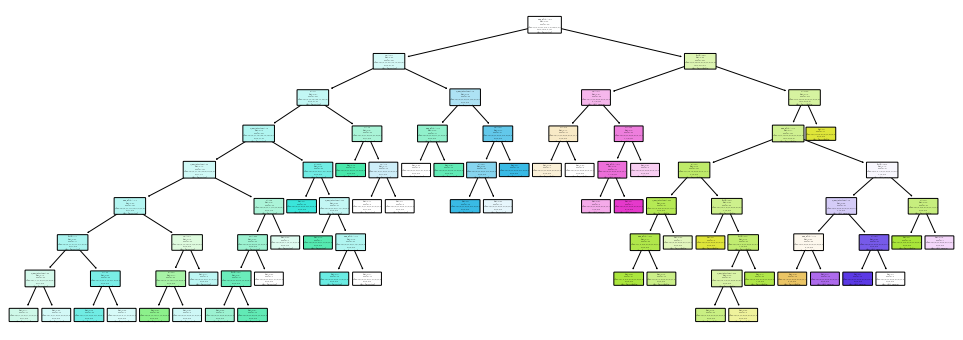

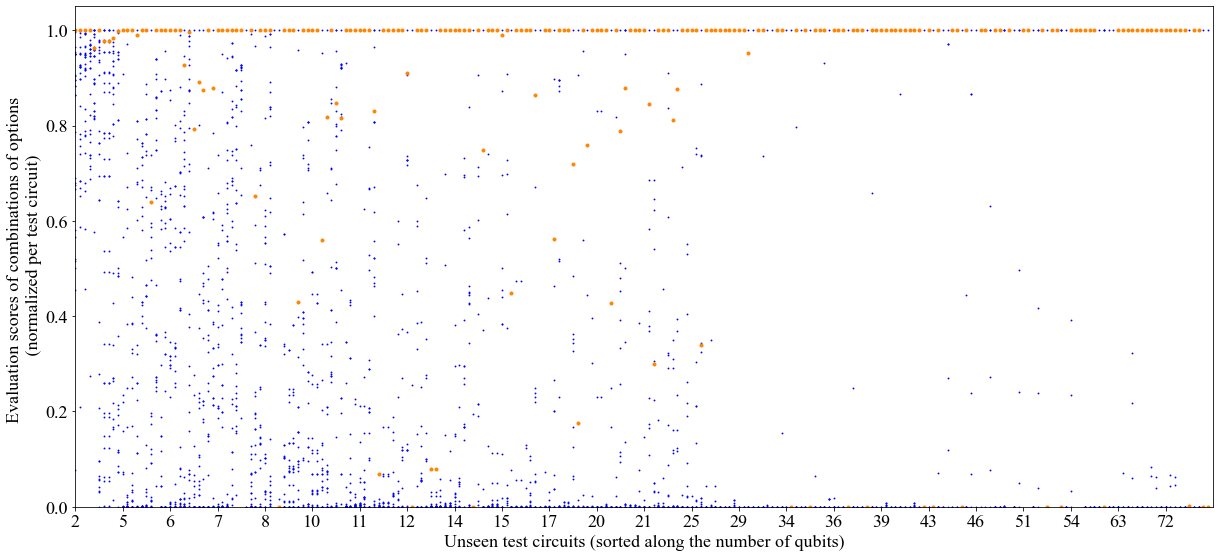

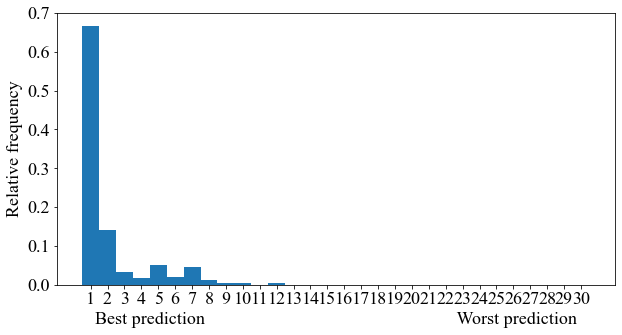

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
X, y = zip(*training_data)
Predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

In [10]:
from numpy import asarray
from numpy import save
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

training_data, names_list, scores_list = utils.load_trainig_data()
X, y = zip(*training_data)
X = list(X)
y = list(y)
for i in range(len(X)):
    X[i] = list(X[i])
    scores_list[i] = list(scores_list[i])

Number of used and non-zero features:  27


/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best GridSearch Estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=14, max_features=21,
                       max_leaf_nodes=162, min_samples_leaf=2, random_state=5)
Best GridSearch Params:  {'criterion': 'entropy', 'max_depth': 14, 'max_features': 21, 'max_leaf_nodes': 162, 'min_samples_leaf': 2, 'min_samples_split': 2}
Num Training Circuits:  1418
Num Test Circuits:  608
Best Training accuracy:  0.7242621808590056
Test accuracy:  0.71875
Compilation paths from Train Data:  {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Compilation paths from Test Data:  {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20}
Compilation paths from Predictions:  {3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20}
# Entries Graph:  608


/Users/nils/Documents/repos/MQTPredictor/predictor/driver.py:348: RuntimeWarning: overflow encountered in double_scalars
  plt.plot(i, tmp_res[j] / max_score, "b.", alpha=1.0, markersize=1.7)
/Users/nils/Documents/repos/MQTPredictor/predictor/driver.py:352: RuntimeWarning: overflow encountered in double_scalars
  tmp_res[y_pred_sorted_accordingly[i]] / max_score,


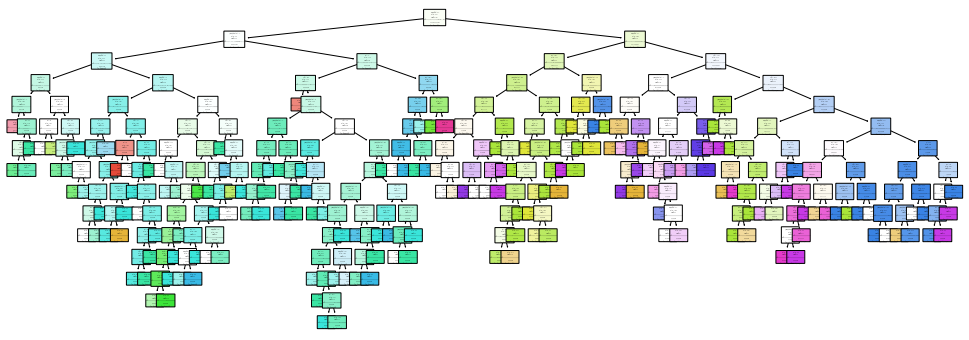

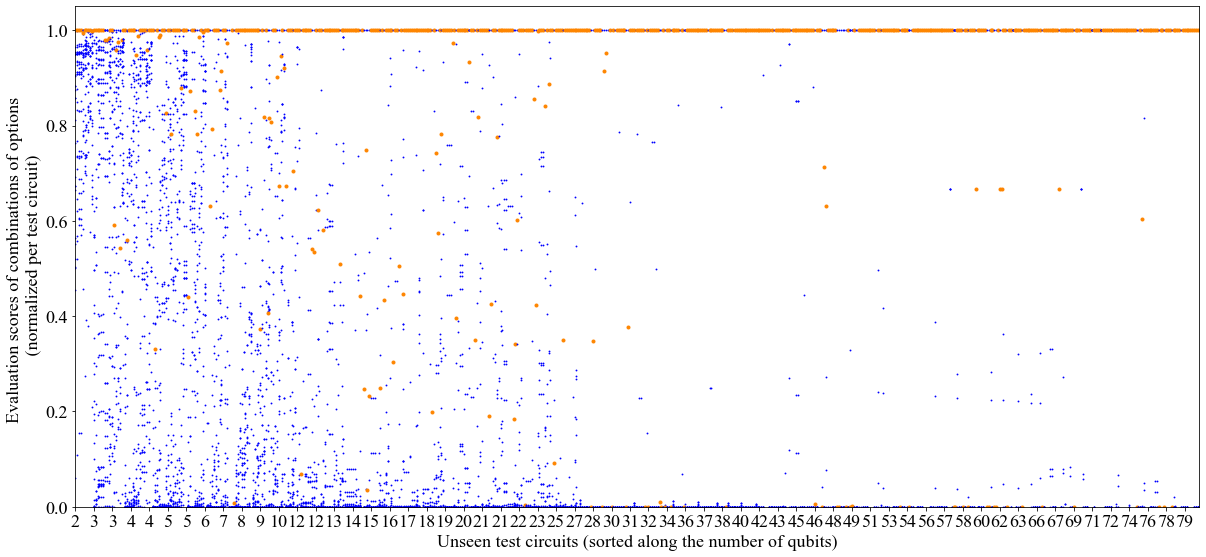

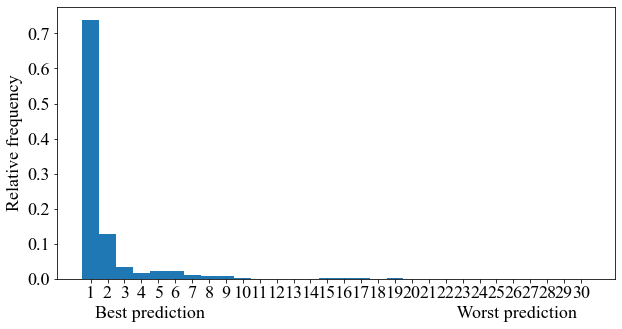

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
Predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

# Random Forest

In [18]:
X, y, indices = np.array(X), np.array(y), np.array(range(len(y)))
(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X, y, indices, test_size=0.3, random_state=5)

scores_filtered = [scores_list[i] for i in indices_test]

Accuracy:  0.7220394736842105


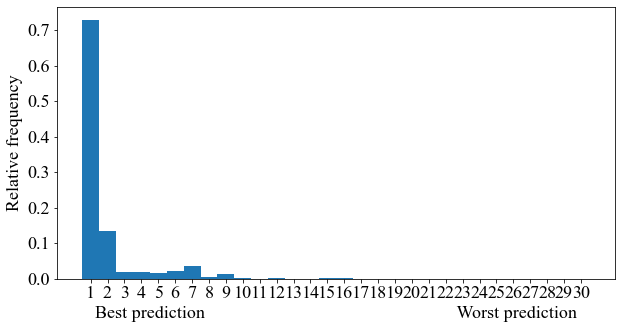

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

print("Accuracy: ", clf.score(X_test, y_test))
y_pred = np.array(list(clf.predict(X_test)))
Predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

# Nearest Neighbor

Accuray:  0.6529605263157895


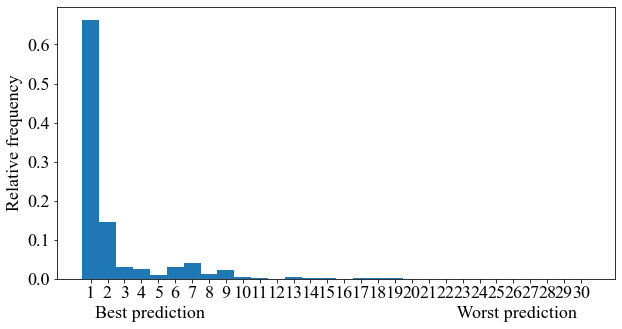

In [32]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

print("Accuracy: ", neigh.score(X_test, y_test))
y_pred = np.array(list(neigh.predict(X_test)))
Predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

# Adaboost

Accuracy:  0.31743421052631576


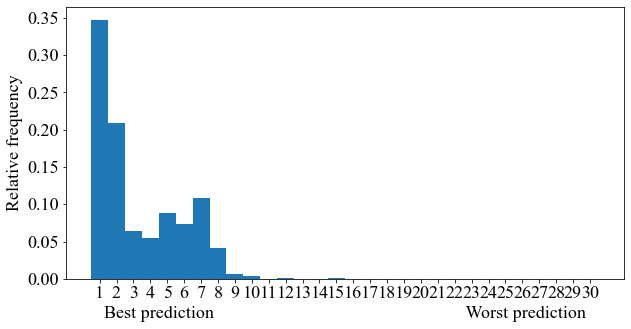

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier


clf = AdaBoostClassifier(n_estimators=1, random_state=0)
clf.fit(X_train, y_train)
print("Accuracy: ", clf.score(X_test, y_test))
y_pred = np.array(list(clf.predict(X_test)))
Predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

# SVM

Accuracy:  0.40625


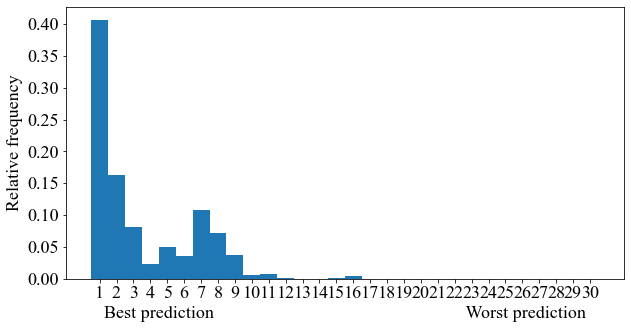

In [47]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)
print("Accuracy: ", clf.score(X_test, y_test))
y_pred = np.array(list(clf.predict(X_test)))
Predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

# Naive Bayes

Accuracy:  0.25164473684210525


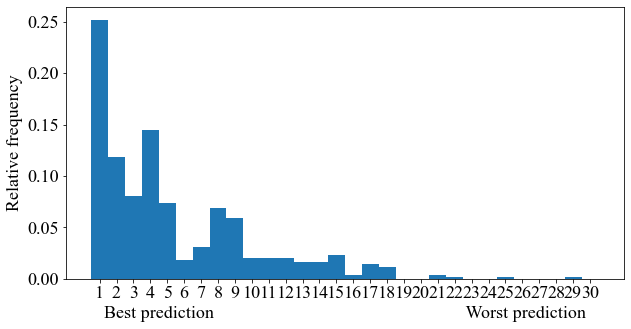

In [49]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print("Accuracy: ", gnb.score(X_test, y_test))
y_pred = np.array(list(gnb.predict(X_test)))
Predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

# SGD

Accuracy:  0.28618421052631576


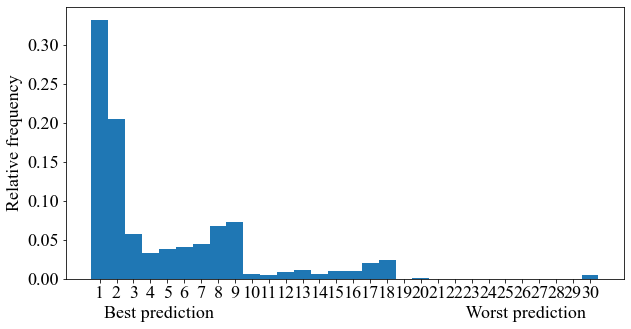

In [75]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=200)
clf.fit(X_train, y_train)
print("Accuracy: ", clf.score(X_test, y_test))
y_pred = np.array(list(clf.predict(X_test)))
Predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

# GradientBoostingClassifier

Accuracy:  0.743421052631579


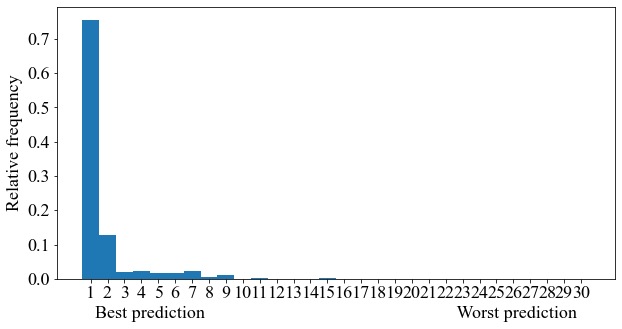

In [53]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(max_iter=100)

clf.fit(X_train, y_train)
print("Accuracy: ", clf.score(X_test, y_test))
y_pred = np.array(list(clf.predict(X_test)))
Predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

# Multi Layer Perceptron

Accuracy:  0.4901315789473684


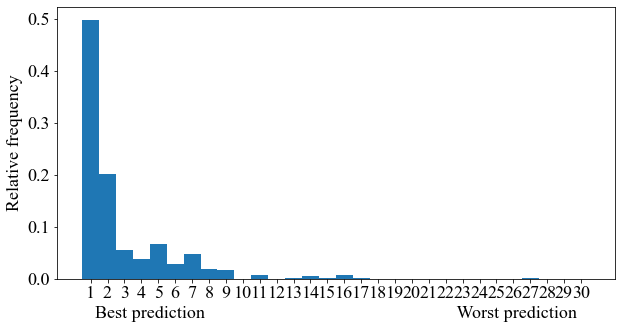

In [72]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver="adam", random_state=0)

clf.fit(X_train, y_train)
print("Accuracy: ", clf.score(X_test, y_test))
y_pred = np.array(list(clf.predict(X_test)))
Predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

# Decision Path Generation

In [ ]:
names_list[30]

In [ ]:
non_zero_indices = []
X = np.array(X)
y = np.array(y)
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]

openqasm_qc_list = utils.get_openqasm_gates()
res = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
res.append("num_qubits")
res.append("depth")
for i in range(1, 6):
    res.append(str(i) + "_max_interactions")

res = [res[i] for i in non_zero_indices]
index = 30
X_test = X[[index]]

clf_instance = Predictor._clf.best_estimator_
n_nodes = clf_instance.tree_.node_count
children_left = clf_instance.tree_.children_left
children_right = clf_instance.tree_.children_right
feature = clf_instance.tree_.feature
threshold = clf_instance.tree_.threshold
node_indicator = clf_instance.decision_path(X_test)
leaf_id = clf_instance.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue
    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=res[feature[node_id]],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )
print("Prediction: ", clf_instance.predict(X_test))

In [ ]:
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.3, random_state=5)
for i in range(19):
    print(y_test.count(i), utils.get_machines()[i])

In [ ]:
print(node_indicator)

# Debugging

In [ ]:
machines = utils.get_machines()
[machines[i] for i in list(Predictor._clf.classes_)]

In [ ]:
from qiskit import QuantumCircuit
from mqt.bench import get_one_benchmark

qc = get_one_benchmark("ghz", 1, 5)

# Nachbehandlung OQC qasm files

In [ ]:
import os
from qiskit import QuantumCircuit

directory = "qasm_compiled"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if "oqc_qiskit" in f:
        with open(f, "r") as f:
            lines = f.readlines()
        new_name = os.path.join("qasm_compiled_postprocessed", filename)
        with open(new_name, "w") as f:
            for line in lines:
                if not (
                    "gate rzx" in line.strip("\n") or "gate ecr" in line.strip("\n")
                ):
                    f.write(line)
                if "gate ecr" in line.strip("\n"):
                    f.write(
                        "gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }\n"
                    )
                    f.write(
                        "gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }\n"
                    )

        qc = QuantumCircuit.from_qasm_file(new_name)
        print("New qasm file for: ", new_name)

    elif "oqc_tket" in f:
        with open(f, "r") as f:
            lines = f.readlines()
        new_name = os.path.join("qasm_compiled_postprocessed", filename)
        with open(new_name, "w") as f:
            count = 0
            for line in lines:
                f.write(line)
                count += 1
                if count == 2:
                    f.write(
                        "gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }\n"
                    )
                    f.write(
                        "gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }\n"
                    )
        qc = QuantumCircuit.from_qasm_file(new_name)
        print("New qasm file for: ", new_name)

# Nachbehandlung: Check if File is readable at all

In [ ]:
import os
from qiskit import QuantumCircuit

directory = "qasm_compiled"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if f.endswith(".qasm"):
        try:
            qc = QuantumCircuit.from_qasm_file(f)
        except Exception as e:
            print("Fail: ", e)
            # Delete file: os.remove(f)

In [60]:
import glob

files = glob.glob("comp_test/ae_indep_qiskit_3*")
print(len(files))

136


In [ ]:
np.median([i for i in range(1, 20)])

# Debugging MQT Bench Integration

In [ ]:
from predictor.driver import Predictor
from predictor.src import utils
from mqt.bench import get_one_benchmark
from qiskit import QuantumCircuit

In [ ]:
Predictor.save_all_compilation_path_results(
    source_path="./comp_test_source", target_path="./comp_test", timeout=5
)
utils.postprocess_ocr_qasm_files(directory="./comp_test")
(
    training_data,
    names_list,
    scores_list,
) = Predictor.generate_trainingdata_from_qasm_files(
    source_path="./comp_test_source", target_path="./comp_test/"
)

In [ ]:
training_data

In [ ]:
X, y = zip(*training_data)
Predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

In [62]:
compilation_pipeline = {
    "devices": {
        "ibm": [("ibm_washington", 127), ("ibm_montreal", 27)],
        "rigetti": [("rigetti_aspen_m1", 80)],
        "ionq": [("ionq11", 11)],
        "oqc": [("oqc_lucy", 8)],
    },
    "compiler": {
        "qiskit": {"optimization_level": [0, 1, 2, 3]},
        "tket": {"lineplacement": [False, True]},
    },
}

In [63]:
type(compilation_pipeline.get("devices"))

dict

In [64]:
index = 0
LUT = {}
for gate_set_name, devices in compilation_pipeline.get("devices").items():
    for device_name, max_qubits in devices:
        for compiler, settings in compilation_pipeline["compiler"].items():
            if "qiskit" in compiler:
                for opt_level in settings["optimization_level"]:
                    LUT[index] = (gate_set_name, device_name, compiler, opt_level)
                    index += 1
            elif "tket" in compiler:
                for lineplacement in settings["lineplacement"]:
                    LUT[index] = (gate_set_name, device_name, compiler, lineplacement)
                    index += 1
print(index)
LUT

30


{0: ('ibm', 'ibm_washington', 'qiskit', 0),
 1: ('ibm', 'ibm_washington', 'qiskit', 1),
 2: ('ibm', 'ibm_washington', 'qiskit', 2),
 3: ('ibm', 'ibm_washington', 'qiskit', 3),
 4: ('ibm', 'ibm_washington', 'tket', False),
 5: ('ibm', 'ibm_washington', 'tket', True),
 6: ('ibm', 'ibm_montreal', 'qiskit', 0),
 7: ('ibm', 'ibm_montreal', 'qiskit', 1),
 8: ('ibm', 'ibm_montreal', 'qiskit', 2),
 9: ('ibm', 'ibm_montreal', 'qiskit', 3),
 10: ('ibm', 'ibm_montreal', 'tket', False),
 11: ('ibm', 'ibm_montreal', 'tket', True),
 12: ('rigetti', 'rigetti_aspen_m1', 'qiskit', 0),
 13: ('rigetti', 'rigetti_aspen_m1', 'qiskit', 1),
 14: ('rigetti', 'rigetti_aspen_m1', 'qiskit', 2),
 15: ('rigetti', 'rigetti_aspen_m1', 'qiskit', 3),
 16: ('rigetti', 'rigetti_aspen_m1', 'tket', False),
 17: ('rigetti', 'rigetti_aspen_m1', 'tket', True),
 18: ('ionq', 'ionq11', 'qiskit', 0),
 19: ('ionq', 'ionq11', 'qiskit', 1),
 20: ('ionq', 'ionq11', 'qiskit', 2),
 21: ('ionq', 'ionq11', 'qiskit', 3),
 22: ('ionq', '

In [ ]:
LUT.get(2)

In [ ]:
from predictor.driver import Predictor
import os
from mqt.bench import benchmark_generator
import pytest
from unittest.mock import patch

In [ ]:
qc = benchmark_generator.get_one_benchmark("dj", 1, 2)
tmp_filename = "test.qasm"
a = qc.qasm(filename=tmp_filename)
# print(a)
res = Predictor.compile_predicted_compilation_path(qc.qasm(), 1)
res

In [ ]:
qc = benchmark_generator.get_one_benchmark("dj", 1, 2)
tmp_filename = "test.qasm"
qc.qasm(filename=tmp_filename)
assert Predictor.compile_all_circuits_for_qc(
    filename=tmp_filename, source_path=".", target_directory="./comp_test/"
)